In [243]:
#Base Libraries
import os 
import sys
import json
import csv

#Core Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygwalker as pyg
import datetime as dt
#Model Libraries
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
#import umap.plot
from sentence_transformers import SentenceTransformer

#ML Libraries
import torch 
import pygwalker as pyg

In [244]:

#Importing Configs
# Define the path where config.py is located
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
database_file = config.database
database_folder = config.database_folder
Word2Vec_Models = config.Word2Vec_models

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [245]:
Body = config.Body
Model = config.Model
Model_Subfolder = f'/{Body} Texts/{Model}'
Model_Folder = config.texts
Model_Folder = Model_Folder + Model_Subfolder

Body_2 = config.Body_2
Model_2 = config.Model_2
Model_Subfolder_2 = f'/{Body_2} Texts/{Model_2}'
Model_Folder_2 = config.texts
Model_Folder_2 = Model_Folder_2 + Model_Subfolder_2

In [246]:
freq_ts = pd.read_csv(f"{Word2Vec_Models}/{Body}/{Model}/keyword_info_ts.csv")
freq_ts_m = freq_ts.copy(deep=True)
freq_ts_m["Year-Month"] = pd.to_datetime(freq_ts_m["Year-Month-Day"])
freq_ts_m['Year-Month'] = freq_ts_m['Year-Month'].dt.to_period('M')
freq_ts_m = freq_ts_m.drop(columns=['Year-Month-Day', 'Type'])
freq_ts_m = freq_ts_m.groupby(['Year-Month', 'Keyword']).sum()
print(freq_ts_m.head())

freq_ts_m = freq_ts_m.reset_index()
print(freq_ts_m.columns)
keys_t = freq_ts_m['Keyword'].tolist()

keys = []
for key in keys_t:
    if key not in keys:
        keys.append(key)
print(keys)

texts = pd.read_csv(f"{Model_Folder}/{Model}_texts.csv")  
texts = texts[['date', 'length']]
texts['date'] = texts['date'].str[0:7]
texts = texts.groupby('date', as_index = False, dropna=True).sum()
texts['length'] = texts['length']/10000
print(texts.head())

texts_2 = pd.read_csv(f"{Model_Folder_2}/{Model_2}_texts.csv")  
texts_2 = texts_2[['date', 'length']]
texts_2['date'] = texts_2['date'].str[0:7]
texts_2 = texts_2.groupby('date', as_index = False, dropna=True).sum()
texts_2['length'] = texts_2['length']/10000
print(texts_2.head())


                         Frequency
Year-Month Keyword                
1998-06    credit                5
           interest             15
           market               27
           unemployment          5
1998-07    credit               18
Index(['Year-Month', 'Keyword', 'Frequency'], dtype='object')
['credit', 'interest', 'market', 'unemployment']
      date   length
0  1998-06   6.7881
1  1998-07   5.5310
2  1998-09  10.5554
3  1998-10  16.2250
4  1998-11   6.3343
      date   length
0  1998-06   1.9700
1  1998-07   5.8780
2  1998-09   8.4852
3  1998-10  14.9608
4  1998-11  20.8378


In [247]:
freq_ts_m.unstack()
print(freq_ts_m.head())
freq_ts_m = freq_ts_m.pivot_table(index='Year-Month', columns='Keyword', values='Frequency')
freq_ts_m = freq_ts_m.reset_index()

# for key in keys:
#     freq_ts_m[f'{key}_diff'] = freq_ts_m[key].diff()
    
freq_ts_m.fillna(0, inplace=True)

  Year-Month       Keyword  Frequency
0    1998-06        credit          5
1    1998-06      interest         15
2    1998-06        market         27
3    1998-06  unemployment          5
4    1998-07        credit         18


In [248]:
freq_ts_2 = pd.read_csv(f"{Word2Vec_Models}/{Body_2}/{Model_2}/keyword_info_ts.csv")
freq_ts_m_2 = freq_ts_2.copy(deep=True)
freq_ts_m_2["Year-Month"] = pd.to_datetime(freq_ts_m_2["Year-Month-Day"])
freq_ts_m_2['Year-Month'] = freq_ts_m_2['Year-Month'].dt.to_period('M')
freq_ts_m_2 = freq_ts_m_2.drop(columns=['Year-Month-Day', 'Type'])
freq_ts_m_2 = freq_ts_m_2.groupby(['Year-Month', 'Keyword']).sum()
print(freq_ts_m_2.head())

freq_ts_m_2 = freq_ts_m_2.reset_index()
print(freq_ts_m_2.columns)

                         Frequency
Year-Month Keyword                
1998-06    credit                0
           interest              0
           market                0
           unemployment          1
1998-07    credit               17
Index(['Year-Month', 'Keyword', 'Frequency'], dtype='object')


In [249]:
freq_ts_m_2.unstack()
print(freq_ts_m_2.head())
freq_ts_m_2 = freq_ts_m_2.pivot_table(index='Year-Month', columns='Keyword', values='Frequency')
freq_ts_m_2 = freq_ts_m_2.reset_index()

# for key in keys:
#     freq_ts_m_2[f'{key}_diff'] = freq_ts_m_2[key].diff()
    
freq_ts_m_2.fillna(0, inplace=True)

  Year-Month       Keyword  Frequency
0    1998-06        credit          0
1    1998-06      interest          0
2    1998-06        market          0
3    1998-06  unemployment          1
4    1998-07        credit         17


In [250]:

freq_ts_m = pd.concat([freq_ts_m, texts], axis=1)
print(freq_ts_m.head())

freq_ts_m_2 = pd.concat([freq_ts_m_2, texts_2], axis=1)
print(freq_ts_m_2.head())

for key in keys:
    freq_ts_m[key] = freq_ts_m[key]/freq_ts_m['length']
    freq_ts_m_2[key] = freq_ts_m_2[key]/freq_ts_m_2['length']


  Year-Month  credit  interest  market  unemployment     date   length
0    1998-06       5        15      27             5  1998-06   6.7881
1    1998-07      18         5      19            13  1998-07   5.5310
2    1998-09      12        11      69             6  1998-09  10.5554
3    1998-10      42        17      93             8  1998-10  16.2250
4    1998-11      19         8      19             0  1998-11   6.3343
  Year-Month  credit  interest  market  unemployment     date   length
0    1998-06       0         0       0             1  1998-06   1.9700
1    1998-07      17         5      27             1  1998-07   5.8780
2    1998-09      14         3      20             0  1998-09   8.4852
3    1998-10      15        15      42             7  1998-10  14.9608
4    1998-11      24        92     104            13  1998-11  20.8378


In [251]:
diffs = freq_ts_m.copy(deep=True)
diffs = diffs[['Year-Month']]

for key in keys:
    diffs[key] = freq_ts_m[key] - freq_ts_m_2[key]
    
print(diffs.head())

  Year-Month    credit  interest    market  unemployment
0    1998-06  0.736583  2.209749  3.977549      0.228969
1    1998-07  0.362244  0.053366 -1.158216      2.180263
2    1998-09 -0.513073  0.688564  4.179893      0.568429
3    1998-10  1.585978  0.045146  2.924559      0.025177
4    1998-11  1.847789 -3.152088 -1.991388     -0.623866


In [252]:
print(freq_ts_m.describe())
print(f"{Body}")

           credit    interest      market  unemployment      length
count  291.000000  291.000000  291.000000    291.000000  291.000000
mean     2.726331    2.091156    4.556638      1.162236   10.960919
std      2.838250    1.982555    2.293478      1.635401    6.671733
min      0.000000    0.000000    0.000000      0.000000    0.555100
25%      1.051232    0.907580    2.939830      0.217720    6.022750
50%      2.044857    1.626325    4.246285      0.607700    9.873300
75%      3.385614    2.526903    5.718960      1.561530   14.851900
max     29.091087   14.577259   20.817620     12.763479   39.216100
Fed


In [253]:
print(freq_ts_m_2.describe())
print(f"{Body_2}")

           credit    interest      market  unemployment      length
count  298.000000  298.000000  298.000000    298.000000  298.000000
mean     1.692969    2.248521    4.626104      0.482789   17.024648
std      1.365133    1.549204    2.250605      1.206586    9.996371
min      0.000000    0.000000    0.000000      0.000000    0.511700
25%      0.675736    1.185285    3.140943      0.099906    9.123400
50%      1.348774    1.921159    4.352898      0.275641   15.950100
75%      2.344870    2.754753    5.642747      0.588081   22.926250
max      8.990940    9.497154   14.327148     19.430681   44.464600
ECB


In [254]:
print(diffs.describe())

           credit    interest      market  unemployment
count  291.000000  291.000000  291.000000    291.000000
mean     1.043362   -0.132966   -0.097049      0.670178
std      2.958218    2.357928    3.114102      1.950149
min     -5.749011   -7.804406   -9.057573    -16.774090
25%     -0.537319   -1.345767   -1.797009     -0.103302
50%      0.647884   -0.286917   -0.086720      0.278681
75%      2.067315    0.891437    1.582456      1.164848
max     27.214611   12.416207   17.321291     12.679832


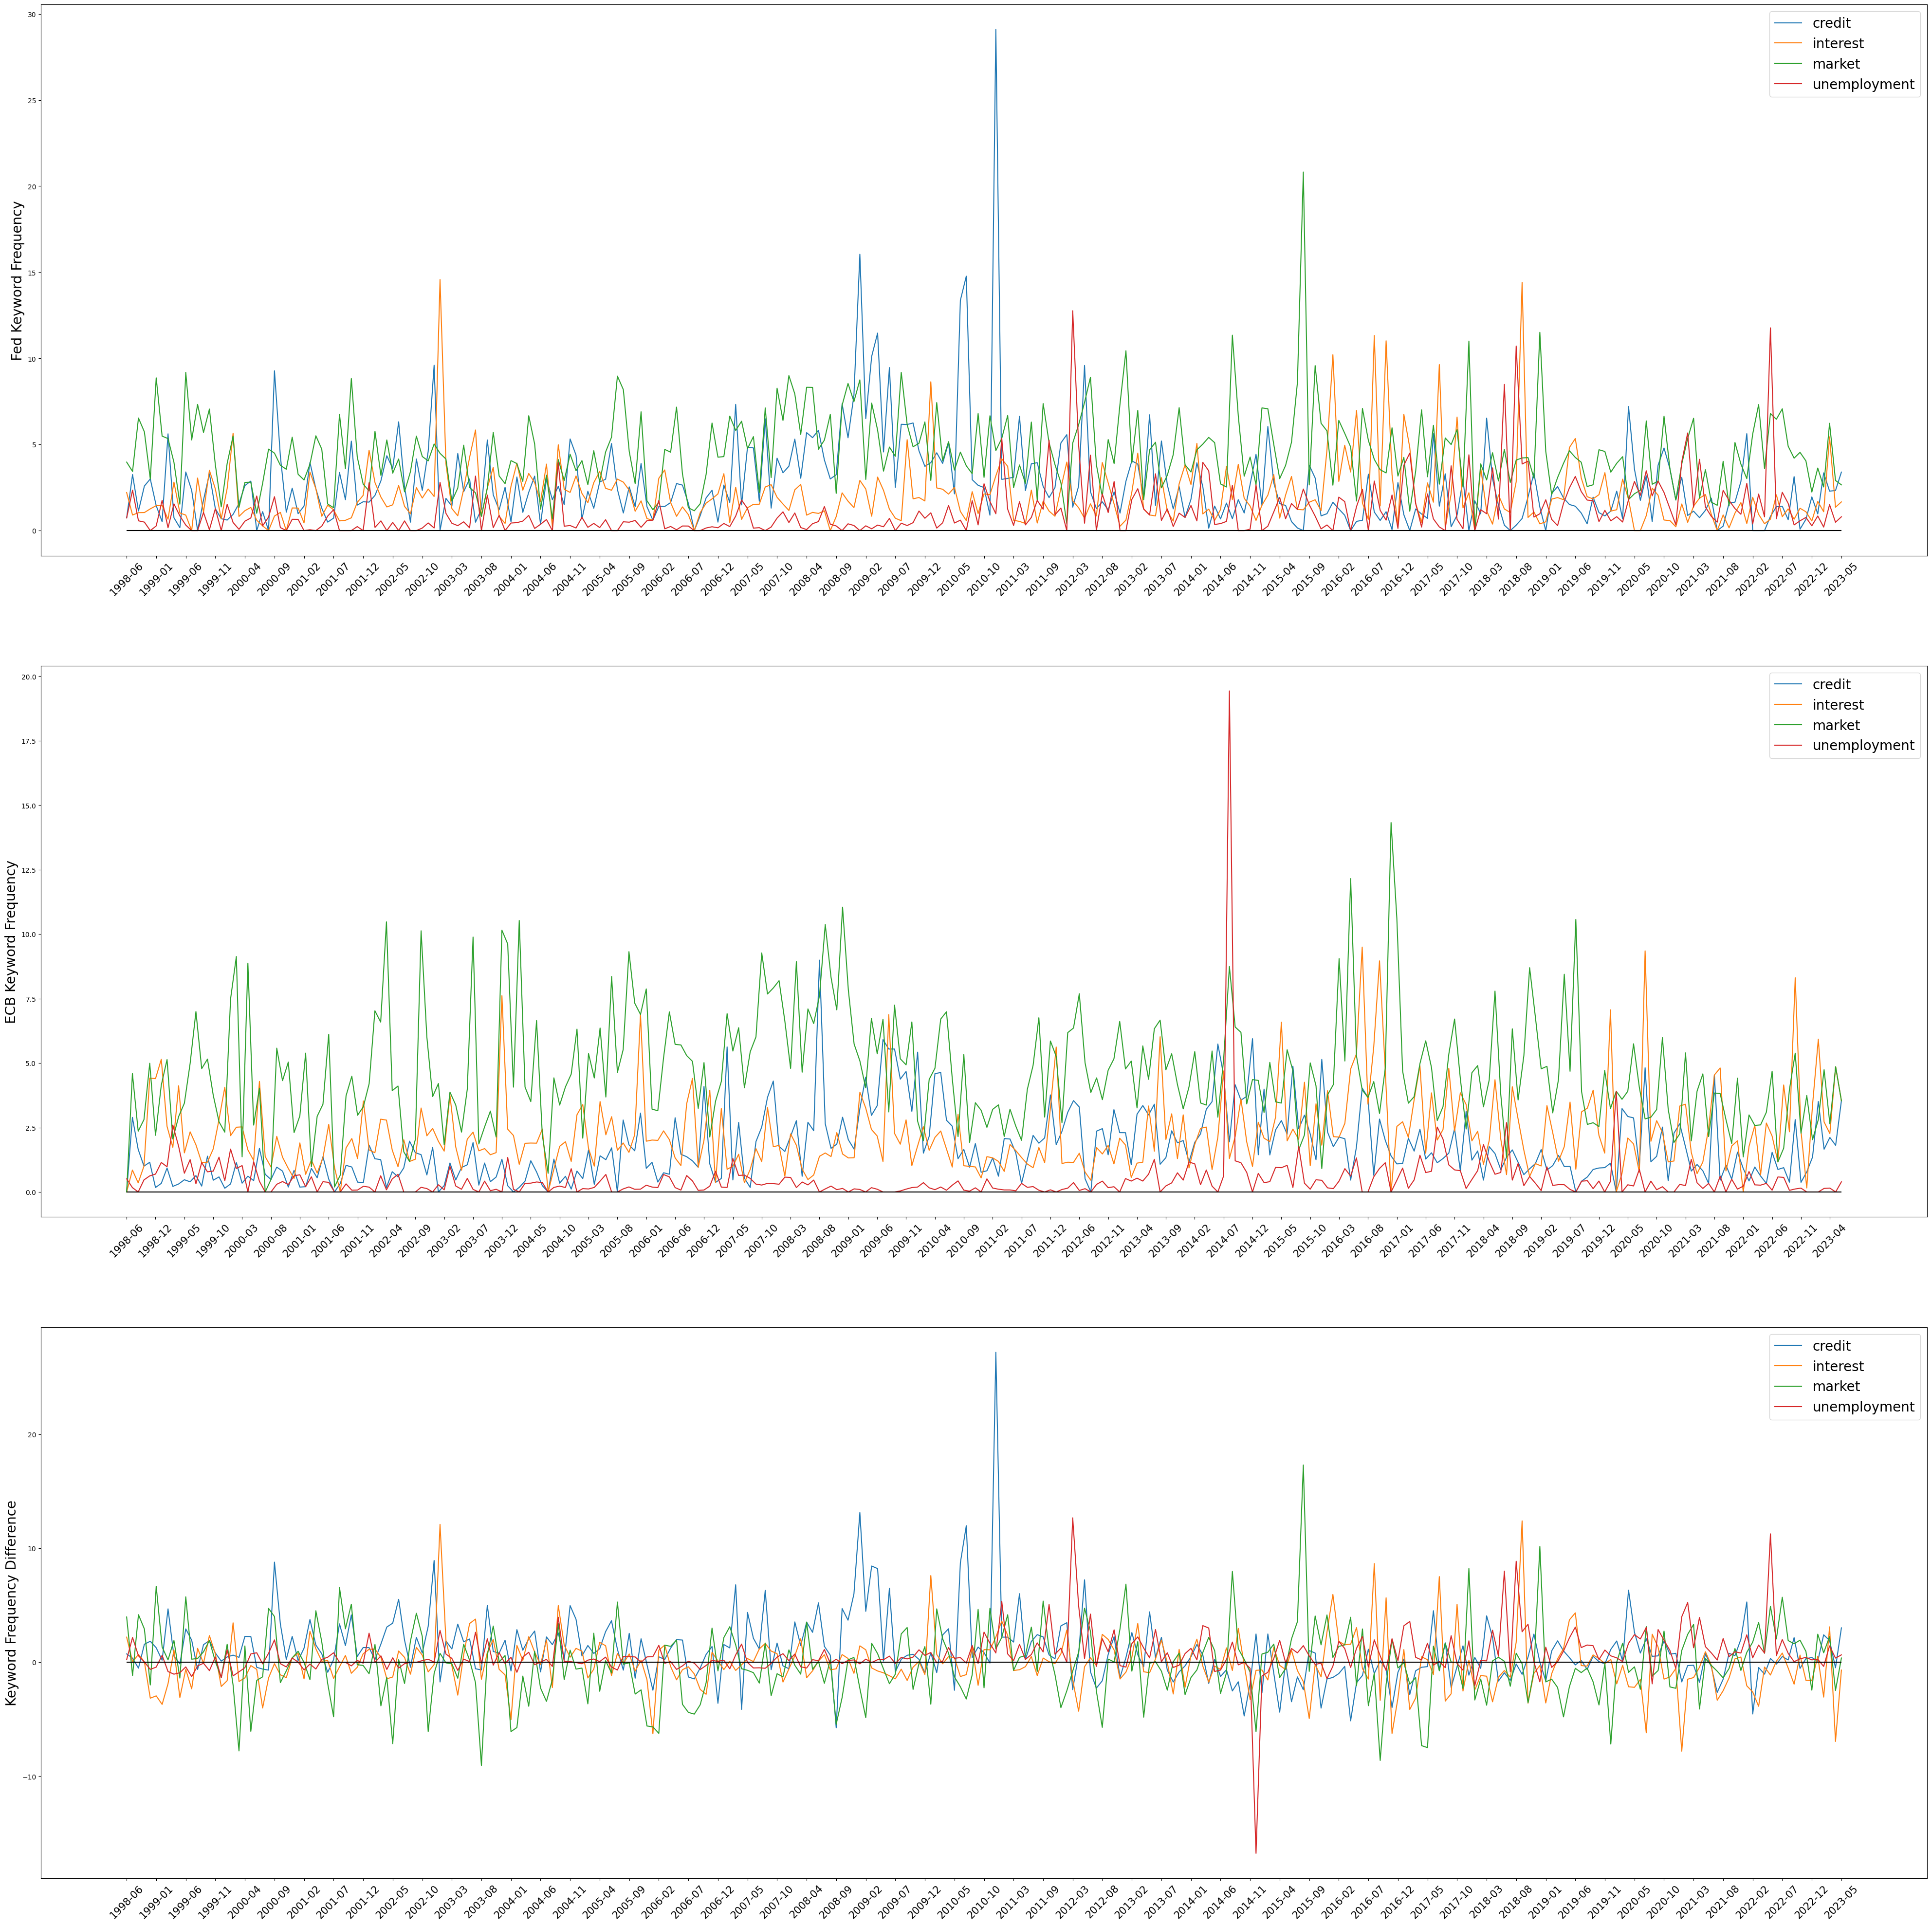

In [255]:


freq_ts_m["Year-Month"] = freq_ts_m["Year-Month"].astype(str)
freq_ts_m_2["Year-Month"] = freq_ts_m_2["Year-Month"].astype(str)
diffs["Year-Month"] = diffs["Year-Month"].astype(str)

# Create a list of x-axis tick positions
num_ticks = 50 
x_tick_positions_1 = freq_ts_m["Year-Month"].iloc[::len(freq_ts_m) // num_ticks].tolist()
x_tick_positions_2 = freq_ts_m_2["Year-Month"].iloc[::len(freq_ts_m) // num_ticks].tolist()
x_tick_positions_3 = diffs["Year-Month"].iloc[::len(freq_ts_m) // num_ticks].tolist()

y=0

fig, axs = plt.subplots(3, 1, figsize=(50, 50))

for key in keys:
    axs[0].plot(freq_ts_m["Year-Month"], freq_ts_m[f'{key}'], label=key)
    axs[1].plot(freq_ts_m_2["Year-Month"], freq_ts_m_2[f'{key}'], label=key)
    axs[2].plot(diffs["Year-Month"], diffs[f'{key}'], label=key)
    
axs[0].hlines(y, freq_ts_m["Year-Month"].min(), freq_ts_m["Year-Month"].max(), color='black')
axs[1].hlines(y, freq_ts_m_2["Year-Month"].min(), freq_ts_m_2["Year-Month"].max(), color='black')
axs[2].hlines(y, diffs["Year-Month"].min(), diffs["Year-Month"].max(), color='black')

axs[0].set_xticks(x_tick_positions_1)
axs[1].set_xticks(x_tick_positions_2)
axs[2].set_xticks(x_tick_positions_3)

#axs[0].set_yticks(np.arange(0, 30, 2))
#axs[1].set_yticks(np.arange(0, 3, 2))
#axs[2].set_yticks(np.arange(-20, 20, 2))

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)
axs[2].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_ylabel(f'{Body} Keyword Frequency', fontsize=20)
axs[1].set_ylabel(f'{Body_2} Keyword Frequency', fontsize=20)
axs[2].set_ylabel(f'Keyword Frequency Difference', fontsize=20)

axs[0].legend(loc='upper right', fontsize=20)
axs[1].legend(loc='upper right', fontsize=20)
axs[2].legend(loc='upper right', fontsize=20)

plt.show()

In [256]:
freq_ts_m = freq_ts_m.pivot_table(index='Year-Month', columns='Keyword', values='Frequency')
print(freq_ts_m.head())

KeyError: 'Frequency'

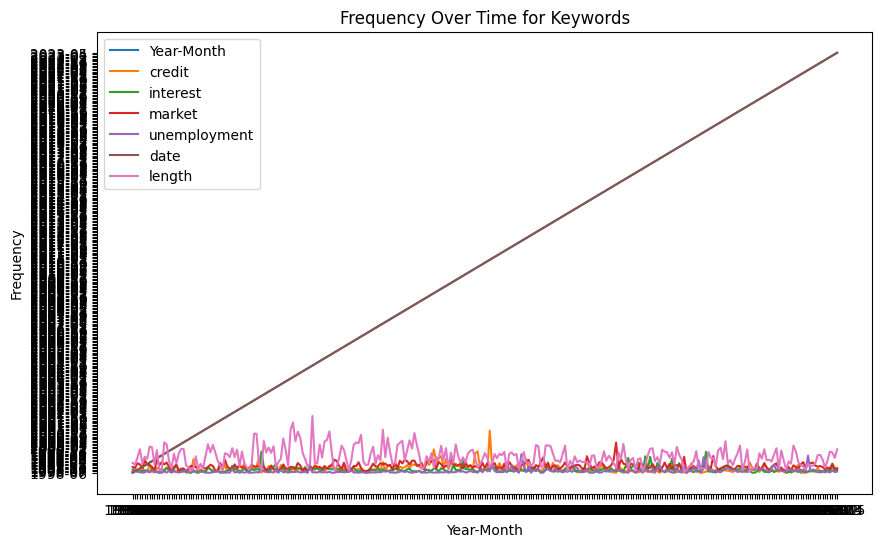

In [ ]:
plt.figure(figsize=(10, 6))
for keyword in freq_ts_m.columns:
    plt.plot(freq_ts_m['Year-Month'].astype(str), freq_ts_m[keyword], label=keyword)

plt.xlabel('Year-Month')
plt.ylabel('Frequency')
plt.title('Frequency Over Time for Keywords')
plt.legend()

In [ ]:
gwalker = pyg.walk(freq_ts_m)

Box(children=(HTML(value='<div id="ifr-pyg-0" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

In [ ]:
freq_ts_m.columns
freq_ts_m.reset_index(inplace=True)
print(freq_ts_m.head())

   index Year-Month    credit  interest    market  unemployment     date  \
0      0    1998-06  0.736583  2.209749  3.977549      0.736583  1998-06   
1      1    1998-07  3.254384  0.903996  3.435184      2.350389  1998-07   
2      2    1998-09  1.136859  1.042121  6.536938      0.568429  1998-09   
3      3    1998-10  2.588598  1.047766  5.731895      0.493066  1998-10   
4      4    1998-11  2.999542  1.262965  2.999542      0.000000  1998-11   

    length  
0   6.7881  
1   5.5310  
2  10.5554  
3  16.2250  
4   6.3343  


In [ ]:
energy = pd.read_csv('/Users/kylenabors/Documents/Database/Other Data/Energy Prices/US Energy CPI.csv')
energy["DATE"] = pd.to_datetime(energy["DATE"]).dt.to_period('M')
freq_ts_m = freq_ts_m.merge(energy, left_on='Year-Month', right_on='DATE', how='left')
print(freq_ts_m.head())
freq_ts_m.drop(columns=['DATE'], inplace=True)

ValueError: You are trying to merge on object and period[M] columns. If you wish to proceed you should use pd.concat

In [ ]:
funds = pd.read_excel('/Users/kylenabors/Documents/Database/Other Data/FedFundsRate.xlsx', sheet_name='Monthly')
funds['Date Adjusted'] = funds['Date Adjusted'].dt.to_period(freq='M')
freq_ts_m = freq_ts_m.merge(funds, left_on='Year-Month', right_on='Date Adjusted', how='left')

In [ ]:
cpi = pd.read_excel('/Users/kylenabors/Documents/Database/Other Data/Urban Consumer CPI.xlsx', sheet_name='Monthly')
cpi['diff'] = cpi['Value'].diff()
print(cpi.head())
cpi["Year-Month"] = pd.to_datetime(cpi["Year-Month"]).dt.to_period('M')
freq_ts_m = freq_ts_m.merge(cpi, left_on='Year-Month', right_on='Year-Month', how='left')
freq_ts_m.drop(columns=['Date Adjusted'], inplace=True)
print(freq_ts_m.head())

In [ ]:
freq_ts_m.rename(columns={'Value_x': 'Energy CPI', 'Value_y': 'Fed Funds Rate', 'Value': 'CPI'}, inplace=True)
print(freq_ts_m.head())

In [ ]:
freq_ts_m.plot(x='Year-Month', y=["decrease", "unemployment", "crisis", "negative", "downward"])

In [ ]:
gwalker = pyg.walk(freq_ts_m)